

# Dataset

Trimmed [Credit risk dataset](https://archive.ics.uci.edu/dataset/144/statlog+german+credit+data) to have only:

<b>Age </b>(numeric)<br>
<b>Sex </b>(text: male, female)<br>
<b>Job </b>(numeric: 0 - unskilled and non-resident, 1 - unskilled and resident, 2 - skilled, 3 - highly skilled)<br>
<b>Housing</b> (text: own, rent, or free)<br>
<b>Saving accounts</b> (text - little, moderate, quite rich, rich)<br>
<b>Checking account </b>(numeric, in DM - Deutsch Mark)<br>
<b>Credit amount</b> (numeric, in DM)<br>
<b>Duration</b> (numeric, in month)<br>
<b>Purpose</b>(text: car, furniture/equipment, radio/TV, domestic appliances, repairs, education, business, vacation/others<br>
<b>Risk </b> (Value target - Good or Bad Risk)<br>

See [german-credit-data-with-risk](https://www.kaggle.com/datasets/kabure/german-credit-data-with-risk) to see the data in Kaggle.


# Note
Install OpenMP runtime on Macbook.
```
brew install libomp
```


# Setup

In [1]:
import json
from collections import Counter # 
import warnings

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.offline as py 
import plotly.graph_objs as go
import plotly.tools as tls

from sklearn.feature_selection import (
    SelectKBest
)
from sklearn.model_selection import (
    cross_val_score,
    KFold,
    GridSearchCV,
    train_test_split
)

from sklearn.pipeline import (
    Pipeline,

    FeatureUnion
)
from sklearn.decomposition import PCA
from sklearn.utils import resample
from sklearn.metrics import (
    accuracy_score, 
    confusion_matrix, 
    classification_report, 
    fbeta_score, 
    recall_score,
    roc_curve,
    roc_auc_score
)
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

warnings.filterwarnings('ignore')
py.init_notebook_mode(connected=True) # this code, allow us to work with offline plotly version

import pandas as pd

# Show full arrays without truncation
pd.set_option('display.max_colwidth', None)   # Prevent shortening of column values
pd.set_option('display.max_seq_items', None)  # Prevent truncation of sequences
pd.set_option('display.expand_frame_repr', False)  # Keep everything in one line per column


In [2]:
%load_ext autoreload
%autoreload 2

from eda import (
    analyse_target_distribution,
    analyse_per_generation,
    analyse_per_property,
    analyse_per_gender,
    analyse_risk_per_saving,
    risk_per_generation,
    risk_per_credit_amount_bin,
    risk_heatmap,
    risk_correlation,
)

from psql import (
    batch_insert_with_progress,
)

ERROR:root:No password found


Password: None


# Data


In [3]:
df = pd.read_csv(
    "../data/csv/german_credit_data.csv",
    index_col=0,
    converters={'Risk': lambda x: {'good': False, 'bad': True}[x]}
)
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,False
1,22,female,2,own,little,moderate,5951,48,radio/TV,True
2,49,male,1,own,little,NaN,2096,12,education,False
3,45,male,2,free,little,little,7882,42,furniture/equipment,False
4,53,male,2,free,little,little,4870,24,car,True


In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
 9   Risk              1000 non-null   bool  
dtypes: bool(1), int64(4), object(5)
memory usage: 79.1+ KB
None


### Column Types

In [5]:
numeric_cols = ['Age', 'Credit amount', 'Duration']
categorical_cols = ['Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']

### Unique Categorical Values

In [6]:
max_len = max(len(col) for col in categorical_cols)

for col in categorical_cols:
    # Convert unique values to string and join them with commas
    unique_values = df[col].dropna().unique()  # optional: remove NaN
    unique_str = ', '.join(str(val) for val in unique_values)
    print(f"{col:<{max_len}} : [{unique_str}]")

Sex              : [male, female]
Job              : [2, 1, 3, 0]
Housing          : [own, free, rent]
Saving accounts  : [little, quite rich, rich, moderate]
Checking account : [little, moderate, rich]
Purpose          : [radio/TV, education, furniture/equipment, car, business, domestic appliances, repairs, vacation/others]


# EDA

## Target label (Risk) and imbalance


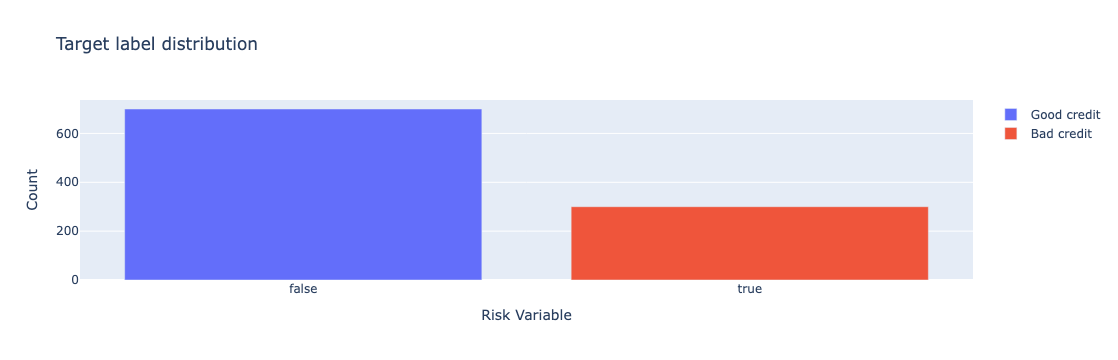

2.3333333333333335

In [7]:
analyse_target_distribution(df=df)
scale = sum(df['Risk'] == False) / sum(df['Risk'] == True)
scale

## Risk by Credit Amount

Higher the amount, higher the risk.


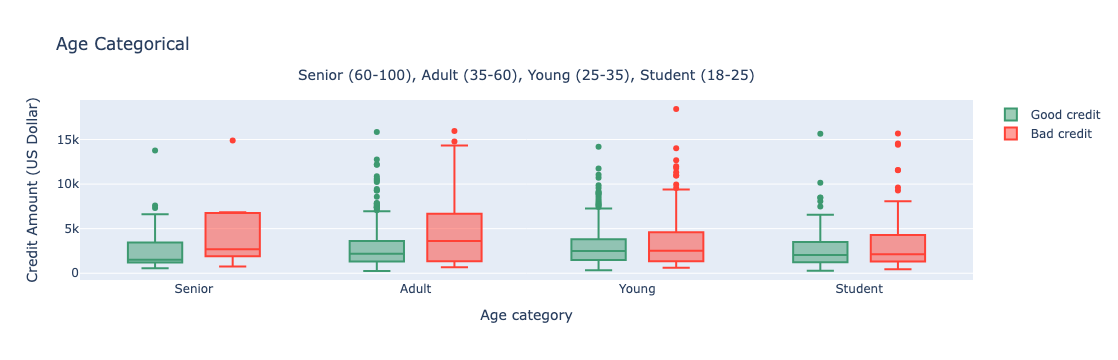

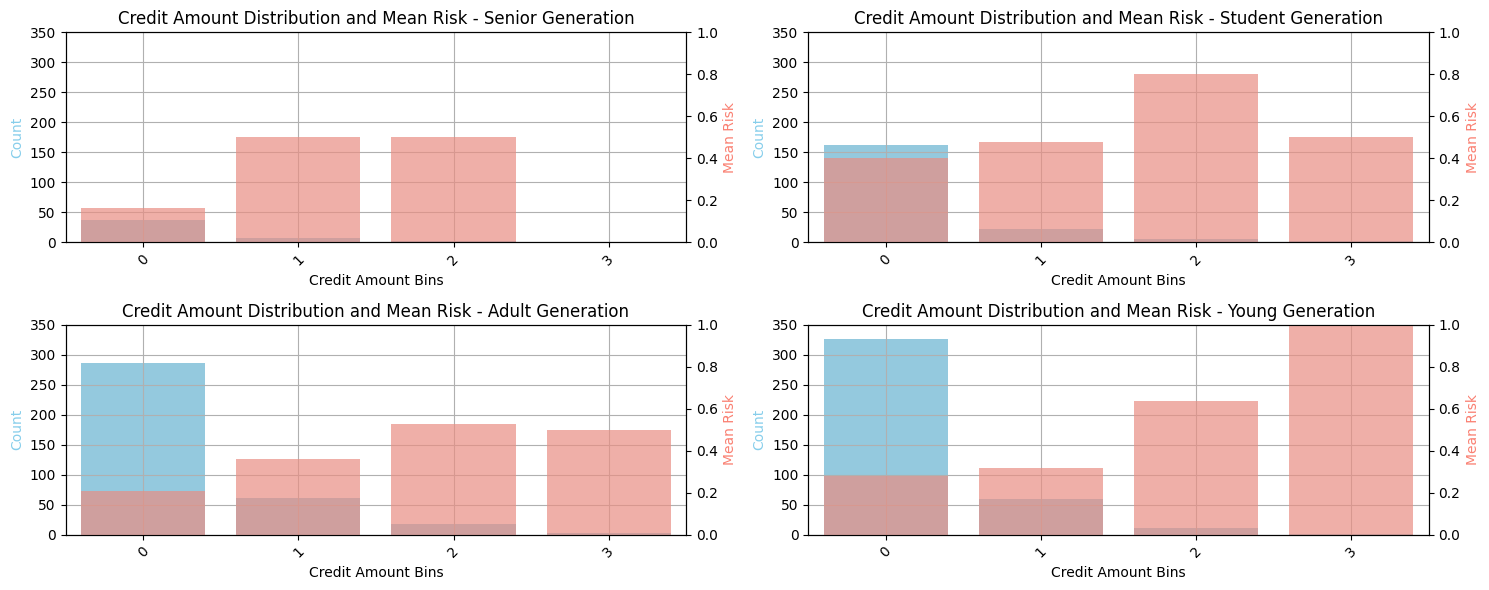

In [8]:
analyse_per_generation(df)
risk_per_credit_amount_bin(df)

if "Generation" not in categorical_cols: categorical_cols += ["Generation"]
if 'Age' in numeric_cols: numeric_cols.remove('Age')

if "Amount" not in categorical_cols: categorical_cols += ["Amount"]
if 'Credit amount' in numeric_cols: numeric_cols.remove('Credit amount')

# Risk Correlation

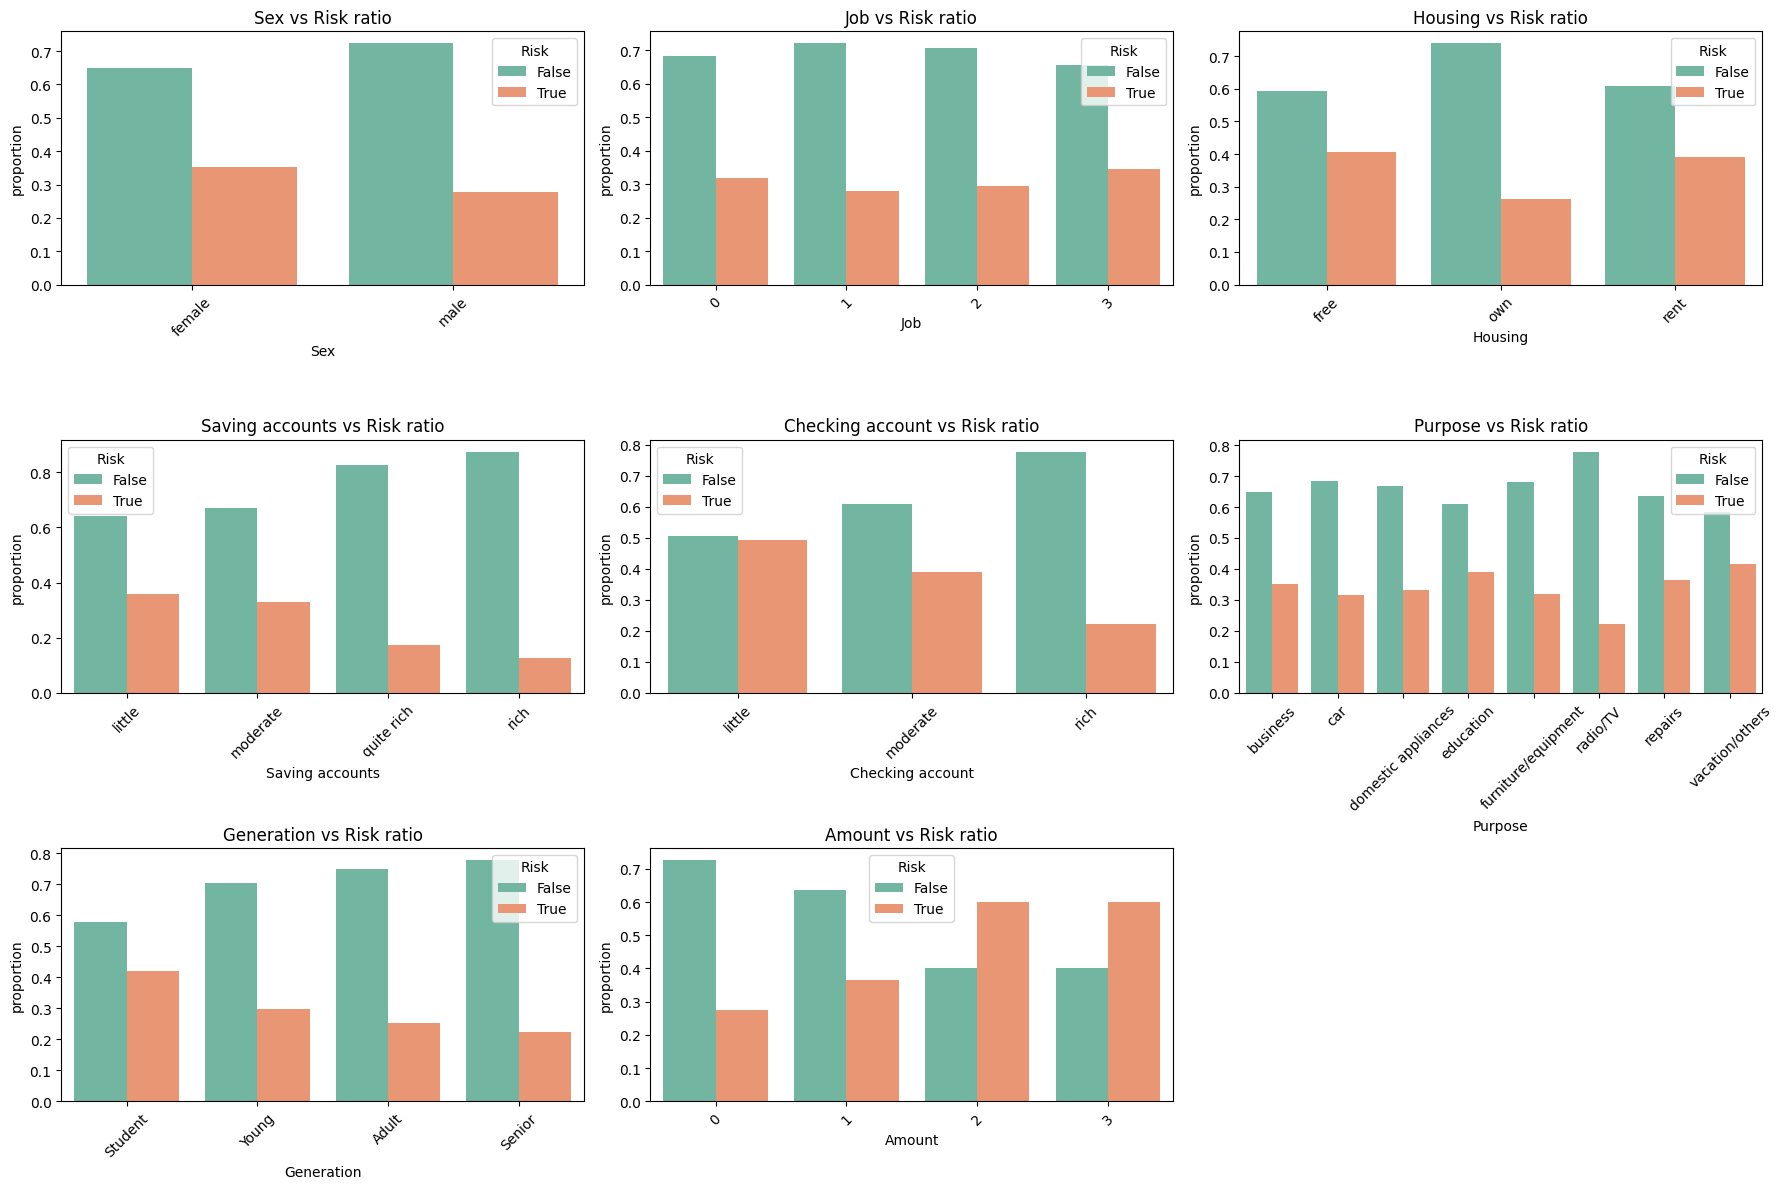

In [9]:
risk_correlation(df, categorical_cols)

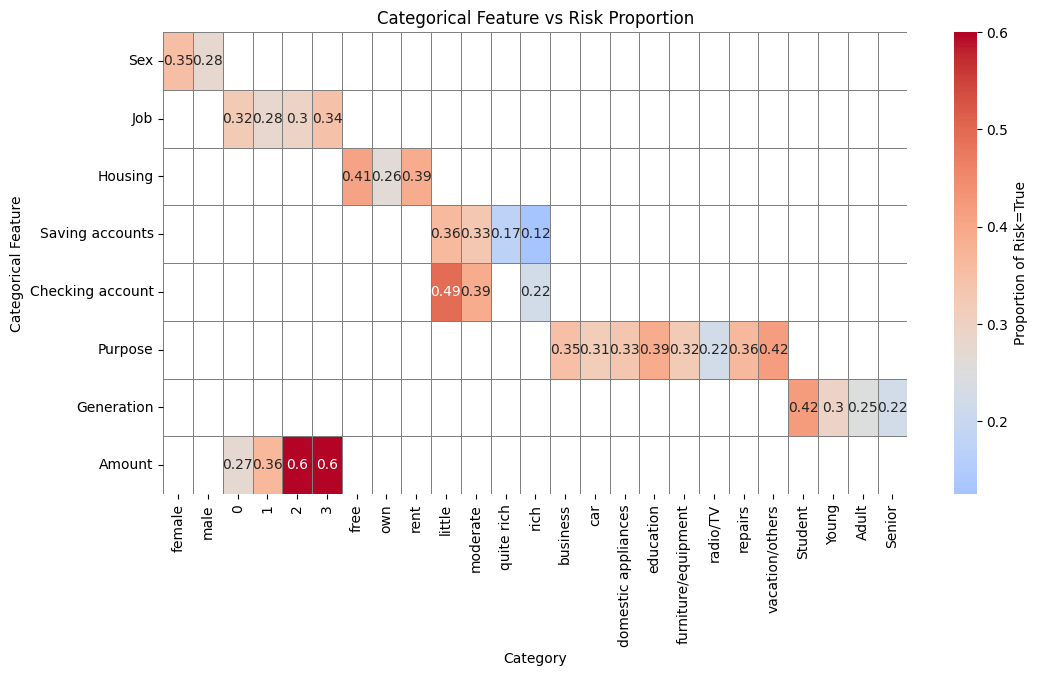

In [10]:
risk_heatmap(df, categorical_cols)

---

# Featur Engineering

In [11]:
df_train = df[numeric_cols + categorical_cols]
# df_train.head()

### Imputation of missing values

In [12]:
df_train['Saving accounts'] = df_train['Saving accounts'].fillna('no_inf')
df_train['Checking account'] = df_train['Checking account'].fillna('no_inf')

### Categorical to One Hot Encoding

In [13]:
df_train = df_train.merge(pd.get_dummies(df_train.Purpose, drop_first=False, prefix='purpose'), left_index=True, right_index=True)
df_train = df_train.merge(pd.get_dummies(df_train.Sex, drop_first=False, prefix='gender'), left_index=True, right_index=True)
df_train = df_train.merge(pd.get_dummies(df_train.Housing, drop_first=False, prefix='property'), left_index=True, right_index=True)
df_train = df_train.merge(pd.get_dummies(df_train["Saving accounts"], drop_first=False, prefix='savings'), left_index=True, right_index=True)
df_train = df_train.merge(pd.get_dummies(df_train["Checking account"], drop_first=False, prefix='check'), left_index=True, right_index=True)
df_train = df_train.merge(pd.get_dummies(df_train["Generation"], drop_first=False, prefix='generation'), left_index=True, right_index=True)
df_train = df_train.merge(pd.get_dummies(df_train["Job"], drop_first=False, prefix='job'), left_index=True, right_index=True)
df_train = df_train.merge(pd.get_dummies(df_train["Amount"], drop_first=False, prefix='amount'), left_index=True, right_index=True)

### Drop unused columns

In [14]:
del df_train["Saving accounts"]
del df_train["Checking account"]
del df_train["Purpose"]
del df_train["Sex"]
del df_train["Housing"]
del df_train["Job"]
del df_train["Duration"]
del df_train["Generation"]
del df_train['Amount']

# Features for Model Consumption

Verify the features to be consumed by the Model Training

In [15]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 0 to 999
Data columns (total 34 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   purpose_business             1000 non-null   bool 
 1   purpose_car                  1000 non-null   bool 
 2   purpose_domestic appliances  1000 non-null   bool 
 3   purpose_education            1000 non-null   bool 
 4   purpose_furniture/equipment  1000 non-null   bool 
 5   purpose_radio/TV             1000 non-null   bool 
 6   purpose_repairs              1000 non-null   bool 
 7   purpose_vacation/others      1000 non-null   bool 
 8   gender_female                1000 non-null   bool 
 9   gender_male                  1000 non-null   bool 
 10  property_free                1000 non-null   bool 
 11  property_own                 1000 non-null   bool 
 12  property_rent                1000 non-null   bool 
 13  savings_little               1000 non-null   bool 
 14

In [16]:
df_train.head()

,purpose_business,purpose_car,purpose_domestic appliances,purpose_education,purpose_furniture/equipment,purpose_radio/TV,purpose_repairs,purpose_vacation/others,gender_female,gender_male,...,generation_Adult,generation_Senior,job_0,job_1,job_2,job_3,amount_0,amount_1,amount_2,amount_3
0,False,False,False,False,False,True,False,False,False,True,...,False,True,False,False,True,False,True,False,False,False
1,False,False,False,False,False,True,False,False,True,False,...,False,False,False,False,True,False,False,True,False,False
2,False,False,False,True,False,False,False,False,False,True,...,True,False,False,True,False,False,True,False,False,False
3,False,False,False,False,True,False,False,False,False,True,...,True,False,False,False,True,False,False,True,False,False
4,False,True,False,False,False,False,False,False,False,True,...,True,False,False,False,True,False,True,False,False,False


---


# Model Training 


In [17]:
#Creating the X and y variables
X = df_train
y = df["Risk"].values

# Spliting X and y into train and test version
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)

## Algorithsm Comparision

Gaussian Naive Bayes gives the best recall.

In [18]:
# to feed the random state
seed = 7

# prepare models
models = []
models.append(('XGB', XGBClassifier(
    scale_pos_weight = scale
)))
models.append(('Gaussian Naive Bayes', GaussianNB()))
models.append(('Logistic Regression', LogisticRegression(
    penalty='l2',          # L2 regularization
    class_weight='balanced', # Automatically adjust weights for imbalanced classes
    solver='liblinear',    # good for small datasets and binary classification
    max_iter=1000,
    random_state=42
)))

# evaluate each model in turn
results = []
# scoring = 'recall'
scoring = 'f1'

for name, model in models:
    kfold = KFold(n_splits=10, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append((name, cv_results))
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

results.sort(reverse=True, key=lambda x: x[1].mean())

XGB: 0.486110 (0.104101)
Gaussian Naive Bayes: 0.525474 (0.082965)
Logistic Regression: 0.599749 (0.080013)


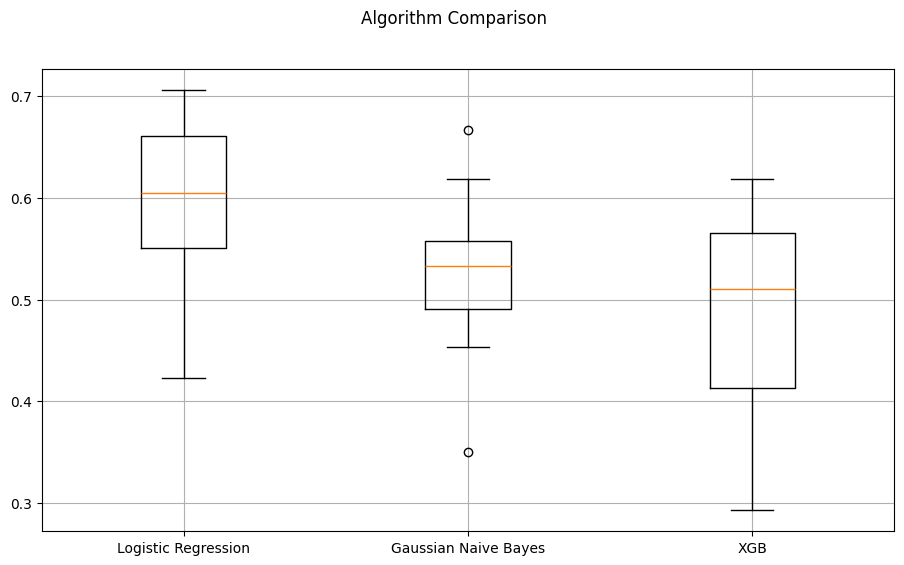

In [19]:
# boxplot algorithm comparison
fig = plt.figure(figsize=(11,6))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot([x[1] for x in results])
ax.set_xticklabels([x[0] for x in results])
plt.grid()
plt.show()

# Train Models


## Logistic Regression

In [20]:
model = LogisticRegression(
    penalty='l2',          # L2 regularization
    class_weight='balanced', # Automatically adjust weights for imbalanced classes
    solver='liblinear',    # good for small datasets and binary classification
    max_iter=1000,
    random_state=42
)

In [21]:
param_grid_logistic = {
    'C': [0.01, 0.1, 1, 10, 100],          # inverse regularization strength
    'penalty': ['l2'],                      # L2 regularization
    'class_weight': ['balanced', None]     # try both balanced and default
}

# GridSearchCV with ROC AUC scoring
grid_logistic = GridSearchCV(
    estimator=model,
    param_grid=param_grid_logistic,
    scoring=scoring,
    cv=5,                # 5-fold cross-validation
    verbose=2,
    n_jobs=-1
)

# Fit GridSearchCV
grid_logistic.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


,estimator,LogisticRegre...r='liblinear')
,param_grid,"{'C': [0.01, 0.1, ...], 'class_weight': ['balanced', None], 'penalty': ['l2']}"
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,penalty,'l2'


In [22]:
print(f"Logistic regression best score: {grid_logistic.best_score_}")
print(json.dumps(grid_logistic.best_params_, indent=4, default=str))

# Best parameters and score
print("Best parameters:", grid_logistic.best_params_)
print("Best ROC:", grid_logistic.best_score_)

Logistic regression best score: 0.5894372219310449
{
    "C": 0.01,
    "class_weight": "balanced",
    "penalty": "l2"
}
Best parameters: {'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l2'}
Best ROC: 0.5894372219310449


NOTE: SKLearn Confusion Matrix format:

```
[[TN FP]
 [FN TP]]
```

Accuracy:0.664
Recall:0.7083333333333334
AUC:0.6772003745318352
Confusion Matrix
[[115  63]
 [ 21  51]]
F-Beta score: 0.6343283582089553
classification report
              precision    recall  f1-score   support

       False       0.85      0.65      0.73       178
        True       0.45      0.71      0.55        72

    accuracy                           0.66       250
   macro avg       0.65      0.68      0.64       250
weighted avg       0.73      0.66      0.68       250



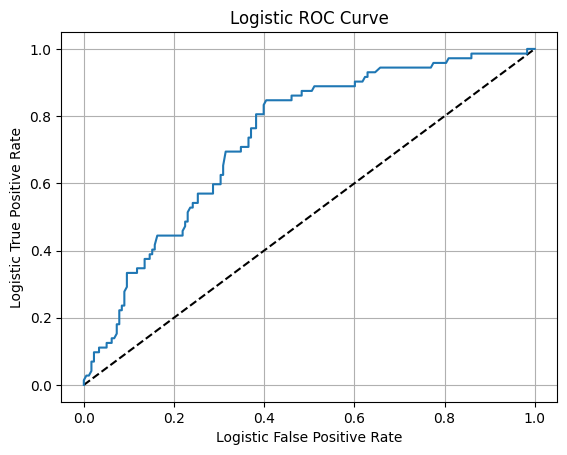

In [23]:
# Evaluate on test set
best_logistic_model = grid_logistic.best_estimator_
y_pred_logistic = best_logistic_model.predict(X_test)

print(f"Accuracy:{accuracy_score(y_test,y_pred_logistic)}")
print(f"Recall:{recall_score(y_test,y_pred_logistic, pos_label=True)}")
print(f"AUC:{roc_auc_score(y_test,y_pred_logistic)}")
print(f"Confusion Matrix\n{confusion_matrix(y_test, y_pred_logistic)}")
print(f"F-Beta score: {fbeta_score(y_test, y_pred_logistic, beta=2)}")
print(f"classification report\n{classification_report(y_test, y_pred_logistic)}")


#Predicting proba
y_pred_prob_logistic = best_logistic_model.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr_logistic, tpr_logistic, thresholds = roc_curve(y_test, y_pred_prob_logistic)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_logistic, tpr_logistic)
plt.xlabel('Logistic False Positive Rate')
plt.ylabel('Logistic True Positive Rate')
plt.grid()
plt.title('Logistic ROC Curve')
plt.show()



## GNB

* [Scikit-Learn GridSearchCV GaussianNB](https://sklearner.com/scikit-learn-grid-search-gaussiannb/)

In [24]:
features = []
features.append(('pca', PCA(n_components=2)))
features.append(('select_best', SelectKBest(k=6)))
feature_union = FeatureUnion(features)

# create pipeline
estimators = []
estimators.append(('feature_union', feature_union))
estimators.append(('logistic', GaussianNB()))
model = Pipeline(estimators)

# evaluate pipeline
seed = 7
kfold = KFold(n_splits=10, random_state=seed, shuffle=True)
results = cross_val_score(model, X_train, y_train, cv=kfold)
print(results.mean())

0.6946666666666668


In [25]:
#model.fit(X_train, y_train)
# Define parameter grid
param_grid = {
    'feature_union__pca__n_components': [1, 2, 3],       # Try different PCA components
    'feature_union__select_best__k': [4, 6, 8],          # Try different number of selected features
    'logistic__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6], # GaussianNB hyperparameter
}

# Create GridSearchCV
grid_gnb = GridSearchCV(model, param_grid, cv=kfold, scoring=scoring, n_jobs=-1)

# Fit
grid_gnb.fit(X_train, y_train)

,estimator,Pipeline(step...aussianNB())])
,param_grid,"{'feature_union__pca__n_components': [1, 2, ...], 'feature_union__select_best__k': [4, 6, ...], 'logistic__var_smoothing': [1e-09, 1e-08, ...]}"
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,KFold(n_split... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformer_list,"[('pca', ...), ('select_best', ...)]"


In [26]:
print(f"GNB best score: {grid_gnb.best_score_}")
print(json.dumps(grid_gnb.best_params_, indent=4, default=str))

GNB best score: 0.5516661003209277
{
    "feature_union__pca__n_components": 3,
    "feature_union__select_best__k": 4,
    "logistic__var_smoothing": 1e-09
}


Accuracy:0.692
Recall:0.625
AUC:0.6720505617977528
Confusion Matrix
[[128  50]
 [ 27  45]]
F-Beta score: 0.587467362924282
classification report
              precision    recall  f1-score   support

       False       0.83      0.72      0.77       178
        True       0.47      0.62      0.54        72

    accuracy                           0.69       250
   macro avg       0.65      0.67      0.65       250
weighted avg       0.72      0.69      0.70       250



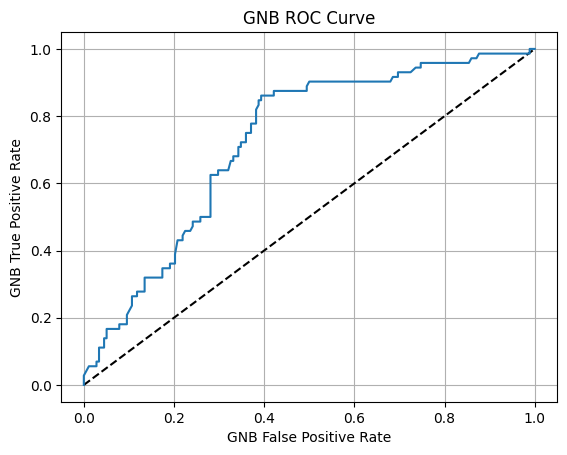

In [27]:
# y_pred_gnb = model.predict(X_test)
best_gnb_model = grid_gnb.best_estimator_
y_pred_gnb = best_gnb_model.predict(X_test)

print(f"Accuracy:{accuracy_score(y_test,y_pred_gnb)}")
print(f"Recall:{recall_score(y_test,y_pred_gnb, pos_label=True)}")
print(f"AUC:{roc_auc_score(y_test,y_pred_gnb)}")
print(f"Confusion Matrix\n{confusion_matrix(y_test, y_pred_gnb)}")
print(f"F-Beta score: {fbeta_score(y_test, y_pred_gnb, beta=2)}")
print(f"classification report\n{classification_report(y_test, y_pred_gnb)}")

#Predicting proba
#y_pred_prob = model.predict_proba(X_test)[:,1]
y_pred_prob_gnb = best_gnb_model.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr_gnb, tpr_gb, thresholds = roc_curve(y_test, y_pred_prob_gnb)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_gnb, tpr_gb)
plt.xlabel('GNB False Positive Rate')
plt.ylabel('GNB True Positive Rate')
plt.grid()
plt.title('GNB ROC Curve')
plt.show()

## XGB

In [28]:
param_xgb = {
    'max_depth': [3, 5, 8],
    'min_child_weight': [1, 5, 8],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'learning_rate': [0.1, 0.3, 0.5]
}

#Creating the classifier
model_xg = XGBClassifier(random_state=2, n_jobs=-1)

grid_xb = GridSearchCV(model_xg, param_grid=param_xgb, cv=5, scoring=scoring)
grid_xb.fit(X_train, y_train)

,estimator,"XGBClassifier...ree=None, ...)"
,param_grid,"{'colsample_bytree': [0.6, 0.8, ...], 'gamma': [0, 0.1, ...], 'learning_rate': [0.1, 0.3, ...], 'max_depth': [3, 5, ...], ...}"
,scoring,'f1'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'binary:logistic'


In [29]:
grid_xb.best_score_
grid_xb.best_params_

{'colsample_bytree': 0.6,
 'gamma': 0.1,
 'learning_rate': 0.5,
 'max_depth': 3,
 'min_child_weight': 5,
 'subsample': 0.6}

Accuracy:0.712
Recall:0.375
AUC:0.6116573033707865
Confusion Matrix
[[151  27]
 [ 45  27]]
F-Beta score: 0.39473684210526316
classification report
              precision    recall  f1-score   support

       False       0.77      0.85      0.81       178
        True       0.50      0.38      0.43        72

    accuracy                           0.71       250
   macro avg       0.64      0.61      0.62       250
weighted avg       0.69      0.71      0.70       250



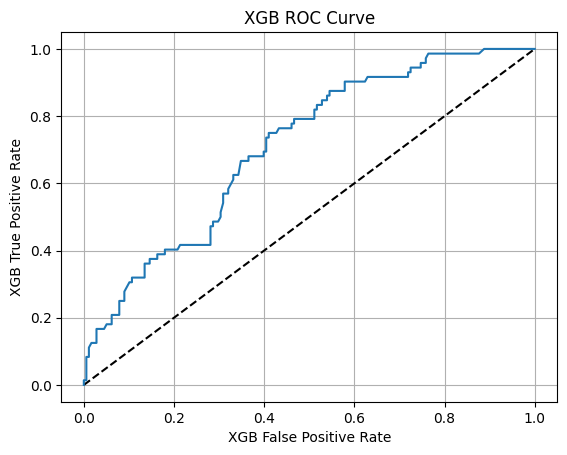

In [30]:
# y_pred = model.predict(X_test)
y_pred_xb = grid_xb.predict(X_test)

print(f"Accuracy:{accuracy_score(y_test,y_pred_xb)}")
print(f"Recall:{recall_score(y_test,y_pred_xb, pos_label=True)}")
print(f"AUC:{roc_auc_score(y_test,y_pred_xb)}")
print(f"Confusion Matrix\n{confusion_matrix(y_test, y_pred_xb)}")
print(f"F-Beta score: {fbeta_score(y_test, y_pred_xb, beta=2)}")
print(f"classification report\n{classification_report(y_test, y_pred_xb)}")

#Predicting proba
#y_pred_prob = model.predict_proba(X_test)[:,1]
y_pred_prob_xb = grid_xb.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr_xb, tpr_xb, thresholds = roc_curve(y_test, y_pred_prob_xb)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_xb, tpr_xb)
plt.xlabel('XGB False Positive Rate')
plt.ylabel('XGB True Positive Rate')
plt.grid()
plt.title('XGB ROC Curve')
plt.show()